<a href="https://colab.research.google.com/github/KowenLin/NTHU_2025_DLIA_HW/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
!tar -xvf drive/MyDrive/cable.tar.gz cable

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
tar: drive/MyDrive/cable.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
#file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/bottle/*/*/*.png')
#file_paths = sorted([path for path in file_paths if path.split('/')[-1] in [f'{i:03}.png' for i in range(10)]])

# === [ 2. 讀取圖片檔案 ] ===

# 確保使用正確路徑
image_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/bottle/*/*/*.png')
image_paths = sorted(image_paths)

In [ ]:
classes = sorted(set([path.split('/')[-2] for path in image_paths]))
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
print(f"Classes: {classes}")

Classes: ['broken_large', 'broken_small', 'contamination', 'good']


In [ ]:
"""
all_data = []

for img in tqdm(file_paths):
    img = cv2.imread(img)
    img = img[..., ::-1]
    all_data.append(img)

all_data = np.stack(all_data)
print(all_data.shape)
"""

all_data = []
all_labels = []

for path in tqdm(image_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = class_to_idx[path.split('/')[-2]]
    all_data.append(img)
    all_labels.append(label)

all_data = np.stack(all_data)
all_labels = np.array(all_labels)


print(set([path.split('/')[1] for path in image_paths]))

import matplotlib.pyplot as plt
import numpy as np


  0%|          | 0/355 [00:00<?, ?it/s]

{'content'}


In [ ]:
#print(set([path.split('/')[1] for path in file_paths]))

print(set([path.split('/')[1] for path in image_paths]))

{'content'}


Classes: ['broken_large', 'broken_small', 'contamination', 'good']


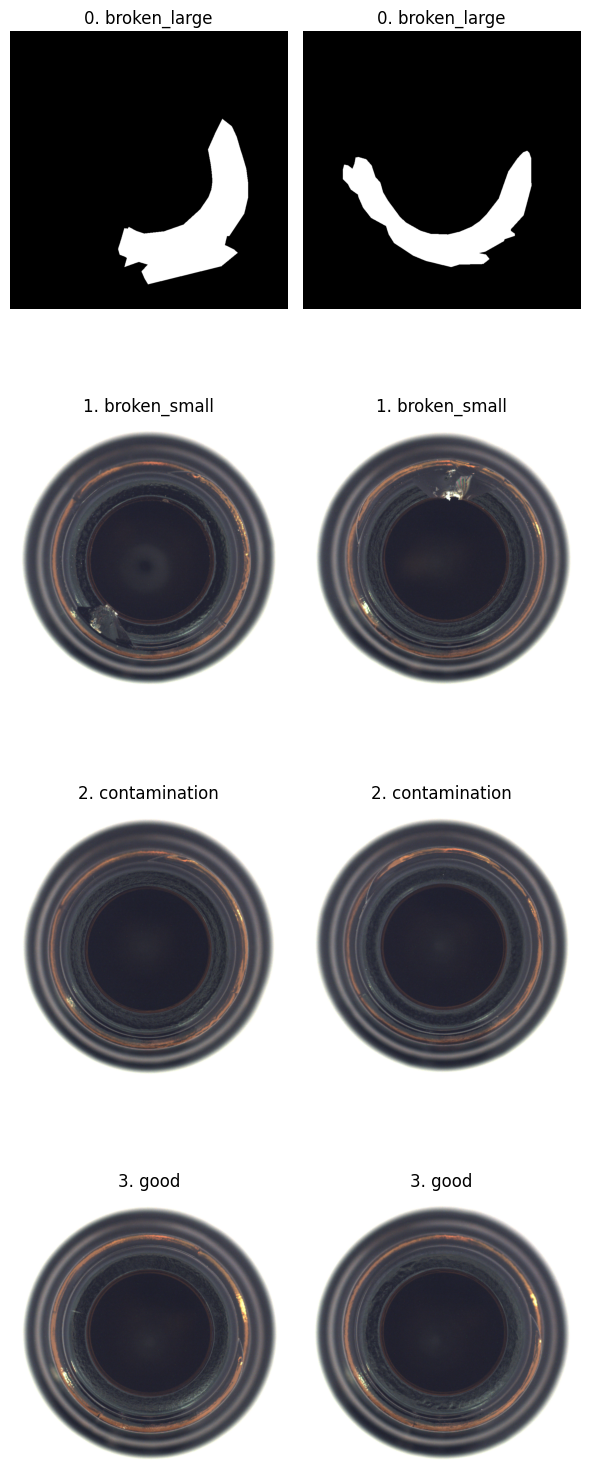

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#classes = sorted(set([path.split('/')[-2] for path in file_paths]))
classes = sorted(set([path.split('/')[-2] for path in image_paths]))
print(f'Classes: {classes}')

images_per_class = len(all_data) // len(classes)
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)),squeeze=False)

for i, class_name in enumerate(classes):
    index = i * images_per_class
    for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

## A. Data Loading and Preprocessing

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
"""
num_classes = 8
images_per_class = 10
train_images_per_class = int(images_per_class * 0.8)
val_images_per_class = int(images_per_class * 0.2)

x_train = []
x_val = []

for i in range(num_classes):
    start_index = i * images_per_class
    x_train.extend(all_data[start_index:start_index + train_images_per_class])
    x_val.extend(all_data[start_index + train_images_per_class:start_index + images_per_class])

# The shape changes from (batch_size, height, width, channels) to (batch_size, channels, height, width)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))

y_train = np.concatenate([np.full(train_images_per_class, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(val_images_per_class, i) for i in range(num_classes)])

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')
"""
# === [ 3. 資料切分 (train/val) ] ===
num_classes = len(classes)
images_per_class = len(all_data) // num_classes
train_ratio = 0.8

x_train = []
x_val = []
y_train = []
y_val = []

for cls_idx in range(num_classes):
    cls_mask = (all_labels == cls_idx)
    cls_images = all_data[cls_mask]
    cls_labels = all_labels[cls_mask]

    split_idx = int(len(cls_images) * train_ratio)
    x_train.extend(cls_images[:split_idx])
    x_val.extend(cls_images[split_idx:])
    y_train.extend(cls_labels[:split_idx])
    y_val.extend(cls_labels[split_idx:])

x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))  # NCHW
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))
y_train = np.array(y_train)
y_val = np.array(y_val)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}, y_val: {y_val.shape}')

x_train: (283, 3, 900, 900), y_train: (283,)
x_val: (72, 3, 900, 900), y_val: (72,)


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        #數據強化
        #transforms.RandomRotation(20),  # 添加旋转增强
        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 颜色增强
        #transforms.RandomVerticalFlip(),  # 添加上下翻转
        #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 平移增强
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),

    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        return self.transform(Image.fromarray(new_x)), self.y[idx]

In [ ]:
batch_size = 32

train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

## B. Defining Neural Networks

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# === [ 5. 使用預訓練模型 ] ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)




#model = models.resnet18(weights='IMAGENET1K_V1')

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
  param.requires_grad = False

#修改預訓練模型M3
#解凍最後一個 block layer4，讓它也可以學習
# Unfreeze layer4 + fc
#for name, param in model.named_parameters():
#    if "layer4" in name or "fc" in name:
#        param.requires_grad = True

"""
num_ftrs = model.fc.in_features
#num_class = 8

# change # of class from 1000 into 8 in the last layer
model.fc = nn.Linear(num_ftrs, num_class)
print(model)
"""

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## C. Training the Neural Network

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm
from torch.optim import AdamW

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 40
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
#使用不同的優化器M1
#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
#原本code
#lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
#使用學習率調度器M4
#改成 StepLR
#lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
#改成 CosineAnnealingLR
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader)*50)

#修改code
for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = outputs.argmax(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = outputs.argmax(1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    lr_scheduler.step()

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "model_classification.pth")
        print(f"Saved best model at epoch {epoch+1} with val_acc: {val_acc}")

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

"""
for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = (images) / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = (images) / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
"""

  0%|          | 0/40 [00:00<?, ?it/s]

Saved best model at epoch 1 with val_acc: 72.22222222222223
Epoch 1/40 - Train Loss: 0.5720, Train Acc: 79.51% | Val Loss: 0.6722, Val Acc: 72.22%
Epoch 2/40 - Train Loss: 0.6392, Train Acc: 79.51% | Val Loss: 0.7080, Val Acc: 70.83%
Epoch 3/40 - Train Loss: 0.6705, Train Acc: 78.45% | Val Loss: 0.6377, Val Acc: 72.22%
Epoch 4/40 - Train Loss: 0.5591, Train Acc: 81.27% | Val Loss: 0.6477, Val Acc: 70.83%
Saved best model at epoch 5 with val_acc: 73.61111111111111
Epoch 5/40 - Train Loss: 0.5932, Train Acc: 79.86% | Val Loss: 0.5840, Val Acc: 73.61%
Epoch 6/40 - Train Loss: 0.5681, Train Acc: 80.21% | Val Loss: 0.6472, Val Acc: 70.83%
Epoch 7/40 - Train Loss: 0.6356, Train Acc: 80.57% | Val Loss: 0.6161, Val Acc: 70.83%
Saved best model at epoch 8 with val_acc: 75.0
Epoch 8/40 - Train Loss: 0.5718, Train Acc: 83.39% | Val Loss: 0.5823, Val Acc: 75.00%
Epoch 9/40 - Train Loss: 0.5459, Train Acc: 83.39% | Val Loss: 0.7109, Val Acc: 70.83%
Epoch 10/40 - Train Loss: 0.5658, Train Acc: 81.63

"\nfor epoch in tqdm(range(epochs)):\n    # Training\n    model.train()\n    total_loss = 0.0\n    train_correct = 0\n    total_train_samples = 0\n\n    for images, labels in train_loader:\n        images = images.cuda()\n        images = (images) / 255.\n        labels = labels.cuda()\n        optimizer.zero_grad()\n        outputs = model(images)\n\n        labels = labels.long()\n\n        loss = criterion(outputs, labels)\n        loss.backward()\n        optimizer.step()\n        total_loss += loss.item()\n\n        train_predicted = outputs.argmax(-1)\n        train_correct += (train_predicted == labels).sum().item()\n        total_train_samples += labels.size(0)\n\n    avg_train_loss = total_loss / len(train_loader)\n    train_accuracy = 100. * train_correct / total_train_samples\n\n    # Validation\n    model.eval()\n    total_val_loss = 0.0\n    correct = 0\n    total = 0\n    with torch.no_grad():\n        for images, labels in val_loader:\n            images = images.cuda()\

### Visualizing model performance

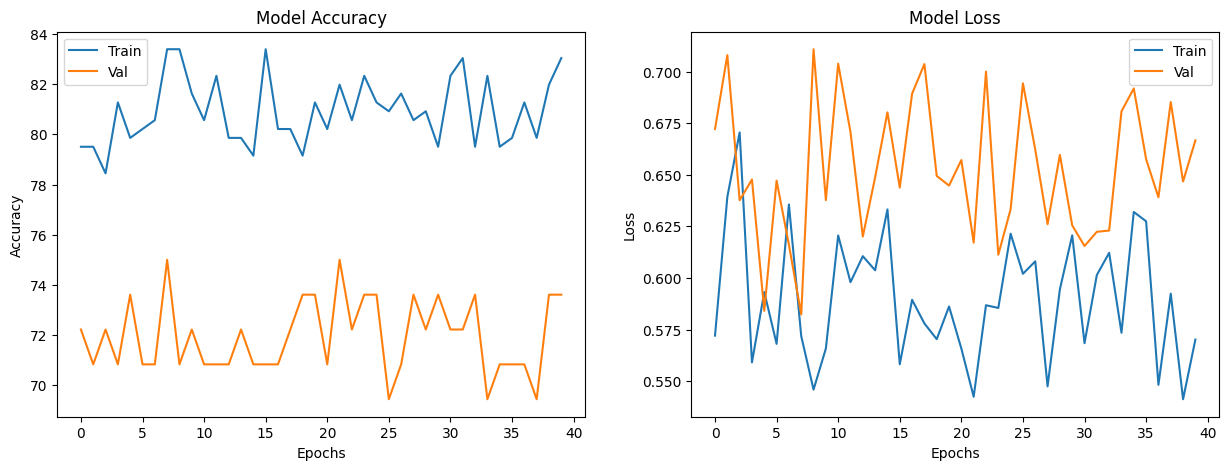

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

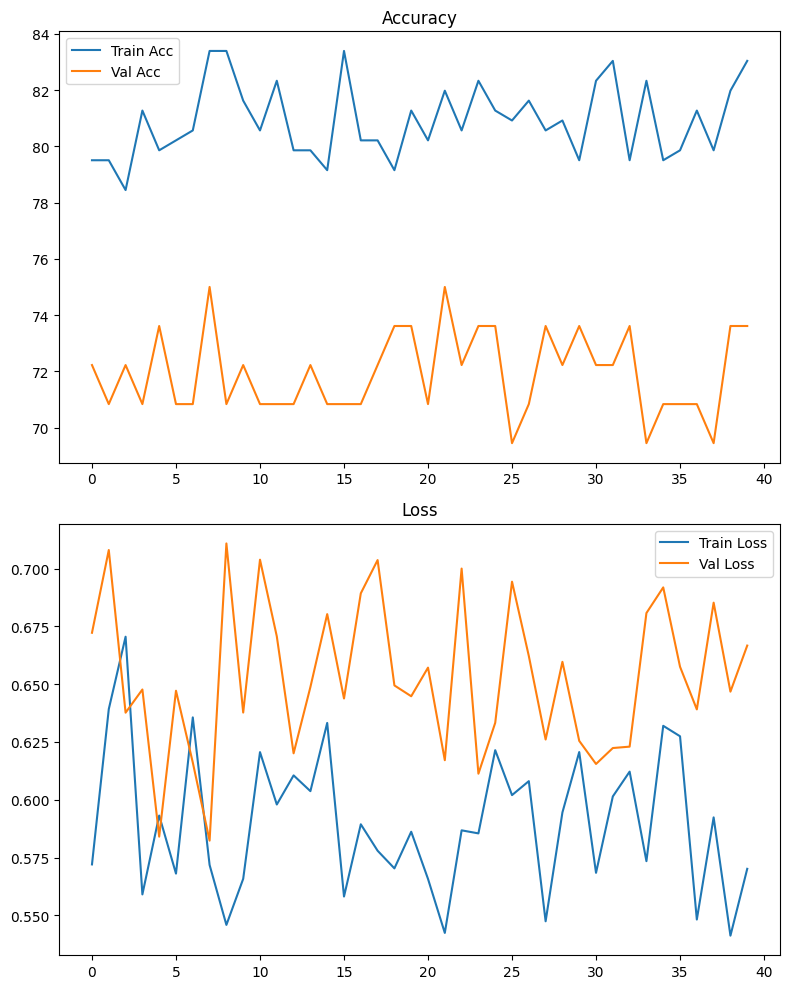

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10))

# 第一張圖：Accuracy
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title("Accuracy")
plt.legend()

# 第二張圖：Loss
plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss")
plt.legend()

plt.tight_layout()  # 調整圖形布局，避免重疊
plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [ ]:
'''
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:

        images = images.cuda()
        images = (images) / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')
'''
model.load_state_dict(torch.load("model_classification.pth"))
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = outputs.argmax(1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")

Test Accuracy: 75.00%


**Question 1**

In [ ]:
import os
from collections import defaultdict
import cv2
import numpy as np

# 設定 bottle 資料集的根路徑（請依實際情況修改）
dataset_root = '/content/drive/MyDrive/Colab Notebooks/bottle'

# 建立統計資料的容器
defect_classes = set()
train_counts = defaultdict(int)
test_counts = defaultdict(int)
image_shapes = []

# 掃描 train 與 test 資料夾
for split in ['train', 'test']:
    split_path = os.path.join(dataset_root, split)
    for cls in os.listdir(split_path):
        class_dir = os.path.join(split_path, cls)
        if not os.path.isdir(class_dir):
            continue
        images = os.listdir(class_dir)
        if split == 'test' and cls != 'good':
            defect_classes.add(cls)
        for img_name in images:
            img_path = os.path.join(class_dir, img_name)
            if split == 'train':
                train_counts[cls] += 1
            else:
                test_counts[cls] += 1
            if len(image_shapes) < 5:  # 隨機取幾張圖看尺寸
                img = cv2.imread(img_path)
                if img is not None:
                    image_shapes.append(img.shape)

# 統計資訊
num_defect_classes = len(defect_classes)
total_images = sum(train_counts.values()) + sum(test_counts.values())
image_shape = image_shapes[0] if image_shapes else (0, 0, 0)

# 輸出結果
print(" Basic Dataset Description for 'bottle'")
print(f"• Number of defect classes: {num_defect_classes}")
print(f"• Types of defect classes: {sorted(defect_classes)}")
print(f"• Number of images used: {total_images}")
print("• Distribution of training data:")
for k, v in train_counts.items():
    print(f"    - {k}: {v}")
print("• Distribution of test data:")
for k, v in test_counts.items():
    print(f"    - {k}: {v}")
print(f"• Image dimensions: {image_shape} (Height x Width x Channels)")


 Basic Dataset Description for 'bottle'
• Number of defect classes: 3
• Types of defect classes: ['broken_large', 'broken_small', 'contamination']
• Number of images used: 292
• Distribution of training data:
    - good: 209
• Distribution of test data:
    - contamination: 21
    - good: 20
    - broken_large: 20
    - broken_small: 22
• Image dimensions: (900, 900, 3) (Height x Width x Channels)


**Question 2**

original

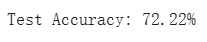
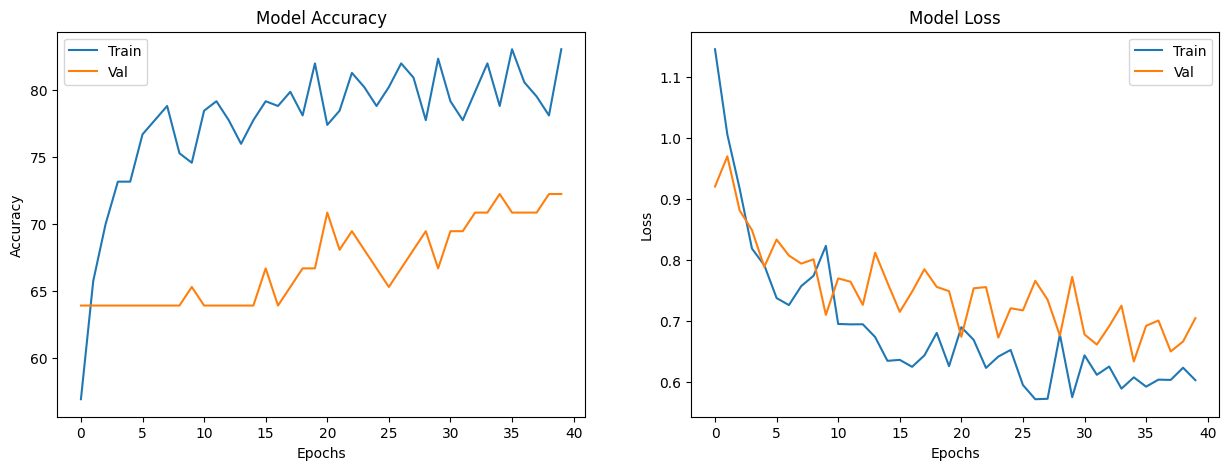

Method 1 使用不同的優化器



In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

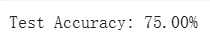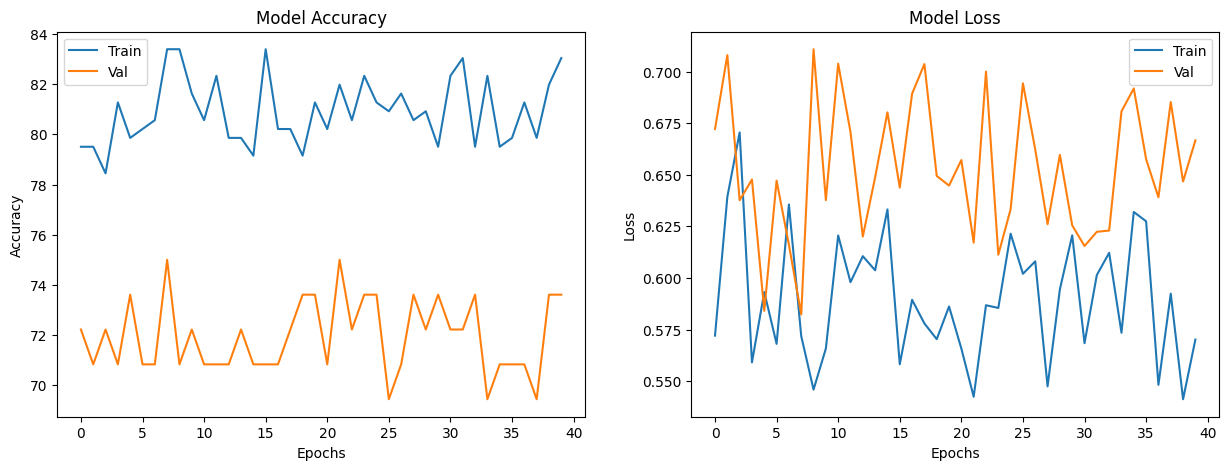

Method 2 數據增強

In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        #數據強化
        transforms.RandomRotation(20),  # 添加旋转增强
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 颜色增强
        transforms.RandomVerticalFlip(),  # 添加上下翻转
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 平移增强
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),

    ]
)

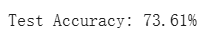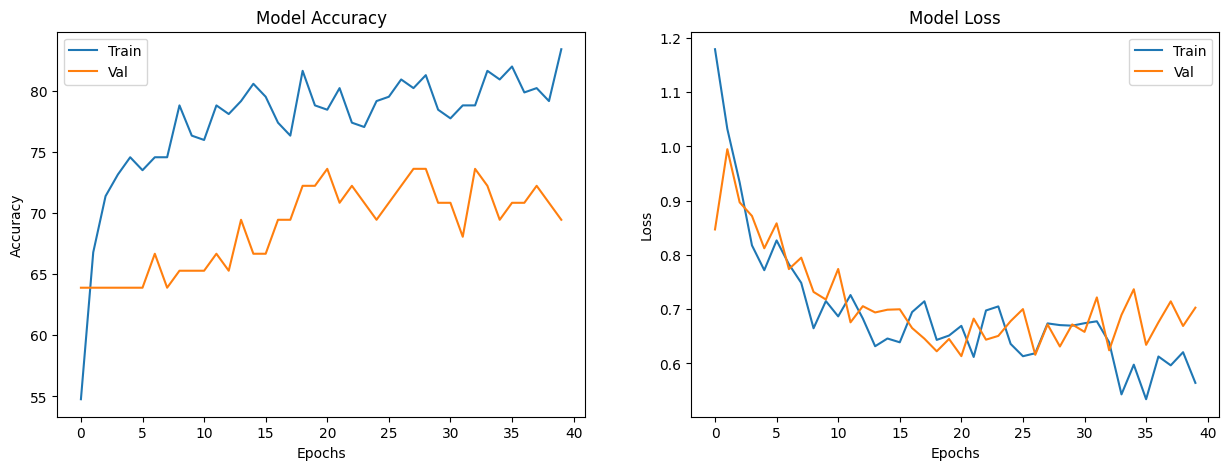

Method 3 修改預訓練模型

In [ ]:
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer4 + fc
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

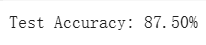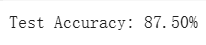

Method 4 調整學習率調度器

In [ ]:
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader)*50)

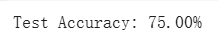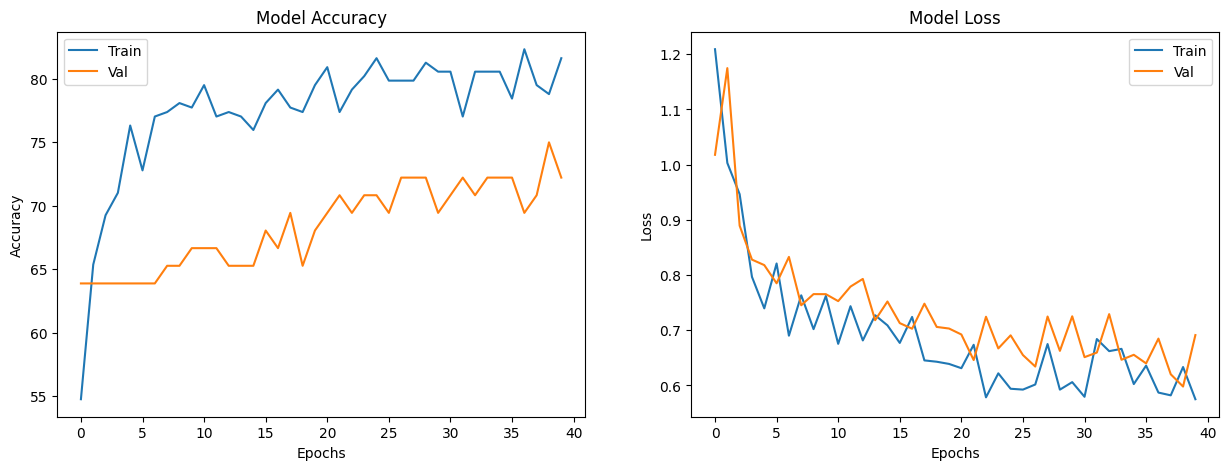